In [51]:
# Mount into drive

from google.colab import drive

drive.mount("/content/drive")

%cd '/content/drive/MyDrive/ThermoEduTech-main/notebooks/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/ThermoEduTech-main/notebooks


In [52]:
pip install loguru

In [53]:
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()))

from utils.metrics import regression_report

In [54]:
import numpy as np
import pandas as pd
import random
import joblib
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM,Dropout
from keras.optimizers import Adam
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [55]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [56]:
# Load the data (created during baseline)
train = pd.read_csv("./tmp_lstm/train.csv")
valid = pd.read_csv("./tmp_lstm/valid.csv")
test = pd.read_csv("./tmp_lstm/test.csv")
df_initial = pd.concat([train, valid,test], ignore_index=True)

def move_column_to_end(df, col_name):
    col = df.pop(col_name)
    df[col_name] = col
    return df

# Assuming your DataFrame is df_initial and you want to move 'measured_t_mean' to the end
df_initial= move_column_to_end(df_initial, 'measured_t_mean')

In [11]:
train

,classroom_type,measured_t_mean,school_day,school_hours,break_time,power_on,trackerwm_avg_mean,shadowwm_avg_mean,sunwm_avg_mean,shadowbandwm_avg_mean,...,rh_mean,ws_ms_s_wvt_mean,winddir_d1_wvt_mean,winddir_sd1_wvt_mean,bp_mb_avg_mean,uva_avg_mean,uvb_avg_mean,Month,Day,Hour
0,0,0.647059,1,0,0,1,0.011026,0.120501,0.020462,0.045077,...,0.785270,0.028474,0.022461,0.032420,0.099109,0.008539,0.093667,3,16,7
1,1,0.638739,1,0,0,1,0.011313,0.145285,0.024634,0.054065,...,0.784698,0.020416,0.014059,0.032387,0.099379,0.008752,0.093545,3,16,7
2,2,0.679674,1,0,0,1,0.033126,0.180489,0.032191,0.066739,...,0.778259,0.071458,0.049206,0.113354,0.100912,0.008796,0.093511,3,16,7
3,4,0.578334,1,0,0,1,0.001889,0.152176,0.025020,0.056610,...,0.792080,0.042610,0.017301,0.060713,0.099583,0.009259,0.093511,3,16,7
4,0,0.690157,1,1,0,1,0.464367,0.192743,0.090702,0.071083,...,0.642038,0.015844,0.110935,0.054132,0.107573,0.008796,0.093511,3,16,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19613,2,0.439509,0,0,0,1,0.457071,0.620993,0.215742,0.239139,...,0.487040,0.368784,0.852444,0.354906,0.350221,0.636290,0.851223,9,3,14
19614,3,0.500634,0,0,0,1,0.494328,0.595069,0.219769,0.228311,...,0.484860,0.337177,0.840079,0.373439,0.350200,0.638112,0.851055,9,3,14
19615,4,0.492879,0,0,0,1,0.433180,0.633180,0.212663,0.238579,...,0.490679,0.368224,0.833983,0.354646,0.350044,0.637062,0.852423,9,3,14
19616,5,0.371462,0,0,0,1,0.420236,0.607855,0.206725,0.233873,...,0.485988,0.360759,0.844526,0.343281,0.350233,0.637704,0.853467,9,3,14


In [57]:
# specify no. of lag hours
n_hours = 6
n_features = 21

# frame as supervised learning
reframed = series_to_supervised(df_initial,n_hours,1)
print(reframed.shape)


(28020, 154)


In [58]:
total_rows = len(reframed)
n_train = int(total_rows * 0.7)
n_val = int(total_rows * 0.1)
n_test = total_rows - n_train - n_val

train = reframed.values[:n_train, :]
val = reframed.values[n_train:n_train + n_val, :]
test = reframed.values[n_train + n_val:, :]

# Number of observations (features) excluding the last one (output variable)
n_obs = n_hours * n_features

# Divide into inputs and outputs
X_train, y_train = train[:, :n_obs], train[:, -1]
X_val, y_val  = val[:, :n_obs], val[:, -1]
X_test, y_test  = test[:, :n_obs], test[:, -1]

# Reshape input to be 3D [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], n_hours, n_features))
X_val = X_val.reshape((X_val.shape[0], n_hours, n_features))
X_test = X_test.reshape((X_test.shape[0], n_hours, n_features))

y_train=y_train.reshape(-1,1)
y_val=y_val.reshape(-1,1)
y_test=y_test.reshape(-1,1)


In [59]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [60]:
scaler_y =joblib.load("./tmp_lstm/assets/min_max_scaler_y.joblib",mmap_mode=None)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [61]:
def plot_results(y_pred_actual, y_test_inv, history, model_name):
    fig, ax = plt.subplots(2, 1, figsize=(12, 6))

    ax[0].plot(y_pred_actual[:168])
    ax[0].plot(y_test_inv[:168])
    ax[0].legend(['prediction', 'actual'], loc='upper left')
    ax[0].set_title(f'Prediction vs Actual Temperature ({model_name})')
    ax[0].set_xlabel('Observation')
    ax[0].set_ylabel('Indoor Temperature')


    ax[1].plot(history.history['loss'], label='Training Loss')
    ax[1].plot(history.history['val_loss'], label='Validation Loss')

    ax[1].legend()
    ax[1].set_title(f'Training and validation MAE ({model_name})')
    ax[1].set_xlabel('Iteration/Epochs')
    ax[1].set_ylabel('MAE')

    fig.tight_layout()
    plt.show()

In [62]:
# Set random seeds for reproducibility
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

In [27]:
model = keras.Sequential()
model.add(layers.GRU(64, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(layers.BatchNormalization())
model.add(layers.Dense(1))

optimizer = Adam()
model.compile(loss='Huber',optimizer=optimizer, metrics=['mae'])

print(model.summary())

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_4 (GRU)                          │ (None, 64)                  │          16,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,025 (66.50 KB)

 Trainable params: 16,897 (66.00 KB)

 Non-trainable params: 128 (512.00 B)

None


In [28]:
# fit network
history = model.fit(X_train, y_train, epochs=1000, batch_size=400,validation_data=(X_test, y_test), verbose=2, shuffle=False)  #, verbose=2, shuffle=False

Epoch 1/1000
50/50 - 2s - 38ms/step - loss: 0.1588 - mae: 0.4176 - val_loss: 0.0979 - val_mae: 0.3742
Epoch 2/1000
50/50 - 0s - 5ms/step - loss: 0.0479 - mae: 0.2389 - val_loss: 0.0410 - val_mae: 0.2206
Epoch 3/1000
50/50 - 0s - 5ms/step - loss: 0.0294 - mae: 0.1885 - val_loss: 0.0377 - val_mae: 0.2168
Epoch 4/1000
50/50 - 0s - 5ms/step - loss: 0.0254 - mae: 0.1748 - val_loss: 0.0452 - val_mae: 0.2338
Epoch 5/1000
50/50 - 0s - 5ms/step - loss: 0.0218 - mae: 0.1626 - val_loss: 0.0548 - val_mae: 0.2531
Epoch 6/1000
50/50 - 0s - 5ms/step - loss: 0.0202 - mae: 0.1576 - val_loss: 0.0694 - val_mae: 0.2838
Epoch 7/1000
50/50 - 0s - 5ms/step - loss: 0.0178 - mae: 0.1479 - val_loss: 0.0882 - val_mae: 0.3170
Epoch 8/1000
50/50 - 0s - 5ms/step - loss: 0.0158 - mae: 0.1395 - val_loss: 0.1299 - val_mae: 0.3953
Epoch 9/1000
50/50 - 0s - 5ms/step - loss: 0.0140 - mae: 0.1317 - val_loss: 0.1716 - val_mae: 0.4604
Epoch 10/1000
50/50 - 0s - 5ms/step - loss: 0.0138 - mae: 0.1308 - val_loss: 0.2278 - val_

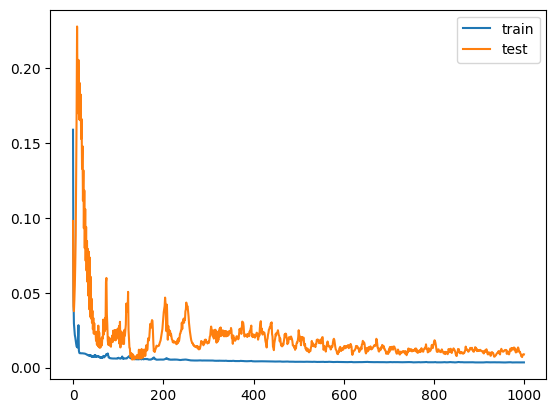

In [29]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
613/613 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
---------------------------------------------------
GRU evaluation for train set:
{'Mean Absolute Error (MAE)': 0.038899722501243135, 'Mean Squared Error (MSE)': 0.002358062509798577, 'Root Mean Squared Error (RMSE)': 0.04855988580915915, 'Mean Absolute Percentage Error (MAPE)': 3435560522.390481, 'R2 Score': 0.8472846617761562}
GRU evaluation for test set:
{'Mean Absolute Error (MAE)': 0.11588463020616088, 'Mean Squared Error (MSE)': 0.017639199836853327, 'Root Mean Squared Error (RMSE)': 0.13281264938571674, 'Mean Absolute Percentage Error (MAPE)': 0.2526751748101012, 'R2 Score': -0.3898116736011574}
---------------------------------------------------



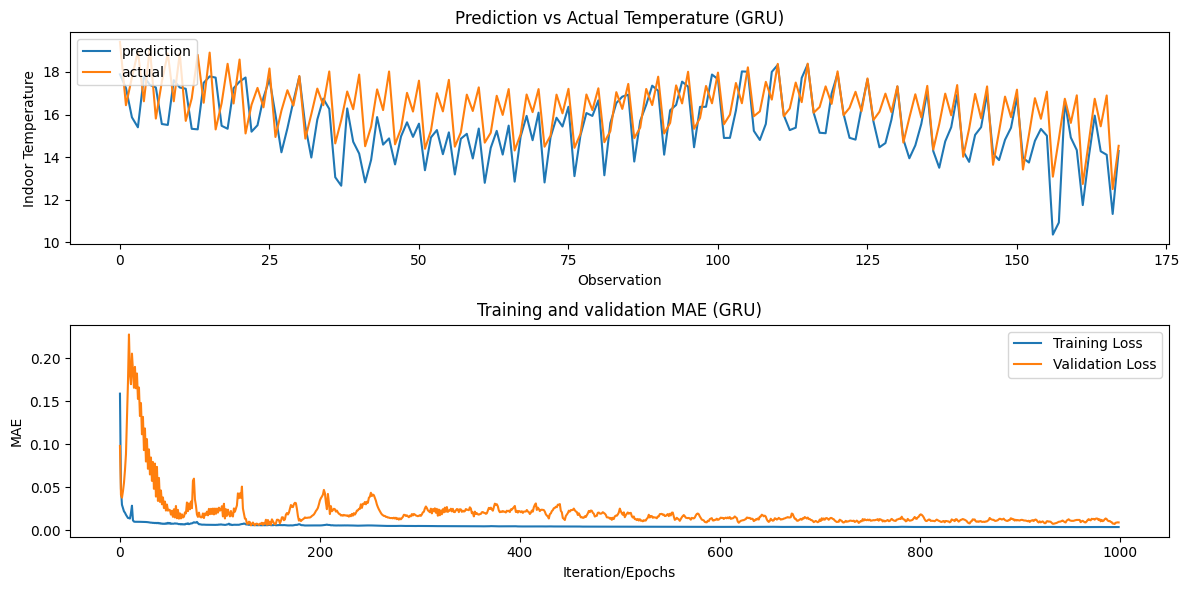

[[0.8472846617761562, 0.038899722501243135, 0.04855988580915915, 3435560522.390481, -0.3898116736011574, 0.11588463020616088, 0.13281264938571674, 0.2526751748101012]]


In [31]:
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)
y_test_inv = scaler_y.inverse_transform(y_test)

results = []

print('---------------------------------------------------')
print(f'GRU evaluation for train set:')
train_report = regression_report(y_train, y_train_pred)
print(train_report)
print(f'GRU evaluation for test set:')
test_report = regression_report(y_pred,y_test)
print(test_report)
print('---------------------------------------------------')
y_pred_actual = scaler_y.inverse_transform(y_pred)
print('')
plot_results(y_pred_actual, y_test_inv, history,'GRU')

results.append([
        train_report['R2 Score'], train_report['Mean Absolute Error (MAE)'], train_report['Root Mean Squared Error (RMSE)'], train_report['Mean Absolute Percentage Error (MAPE)'],
        test_report['R2 Score'], test_report['Mean Absolute Error (MAE)'], test_report['Root Mean Squared Error (RMSE)'], test_report['Mean Absolute Percentage Error (MAPE)']
    ])

print(results)

In [38]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

# design network
model = Sequential()
model.add(layers.Conv2D(32, (5,5), activation = 'relu', input_shape=(X_train.shape[1], X_train.shape[2],1)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(1, activation='linear'))

optimizer = Adam()
model.compile(loss='Huber',optimizer=optimizer, metrics=['mae'])

model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)                    │ (None, 2, 17, 32)           │             832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 1, 8, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,089 (4.25 KB)

 Trainable params: 1,089 (4.25 KB)

 Non-trainable params: 0 (0.00 B)

In [39]:
# fit network
history = model.fit(X_train, y_train, epochs=1000, batch_size=400,validation_data=(X_test, y_test), verbose=2, shuffle=False)  #, verbose=2, shuffle=False

Epoch 1/1000
50/50 - 3s - 58ms/step - loss: 0.0195 - mae: 0.1531 - val_loss: 0.0219 - val_mae: 0.1728
Epoch 2/1000
50/50 - 0s - 3ms/step - loss: 0.0124 - mae: 0.1266 - val_loss: 0.0082 - val_mae: 0.1032
Epoch 3/1000
50/50 - 0s - 2ms/step - loss: 0.0060 - mae: 0.0858 - val_loss: 0.0096 - val_mae: 0.1144
Epoch 4/1000
50/50 - 0s - 3ms/step - loss: 0.0051 - mae: 0.0777 - val_loss: 0.0075 - val_mae: 0.0982
Epoch 5/1000
50/50 - 0s - 2ms/step - loss: 0.0060 - mae: 0.0857 - val_loss: 0.0066 - val_mae: 0.0916
Epoch 6/1000
50/50 - 0s - 2ms/step - loss: 0.0046 - mae: 0.0742 - val_loss: 0.0091 - val_mae: 0.1083
Epoch 7/1000
50/50 - 0s - 2ms/step - loss: 0.0083 - mae: 0.1018 - val_loss: 0.0061 - val_mae: 0.0887
Epoch 8/1000
50/50 - 0s - 3ms/step - loss: 0.0079 - mae: 0.1007 - val_loss: 0.0130 - val_mae: 0.1272
Epoch 9/1000
50/50 - 0s - 2ms/step - loss: 0.0081 - mae: 0.1001 - val_loss: 0.0117 - val_mae: 0.1315
Epoch 10/1000
50/50 - 0s - 2ms/step - loss: 0.0105 - mae: 0.1171 - val_loss: 0.0071 - val_

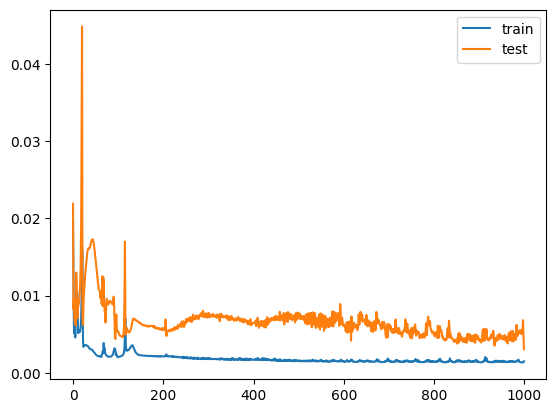

In [40]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
613/613 ━━━━━━━━━━━━━━━━━━━━ 1s 999us/step
---------------------------------------------------
LSTM evaluation for train set:
{'Mean Absolute Error (MAE)': 0.05169107269462219, 'Mean Squared Error (MSE)': 0.004285507032153138, 'Root Mean Squared Error (RMSE)': 0.06546378412644, 'Mean Absolute Percentage Error (MAPE)': 36668749979.31834, 'R2 Score': 0.722457461090872}
LSTM evaluation for test set:
{'Mean Absolute Error (MAE)': 0.06425829304468515, 'Mean Squared Error (MSE)': 0.006111773625548682, 'Root Mean Squared Error (RMSE)': 0.07817783333879676, 'Mean Absolute Percentage Error (MAPE)': 0.1181955052352202, 'R2 Score': 0.3483092553827907}
---------------------------------------------------



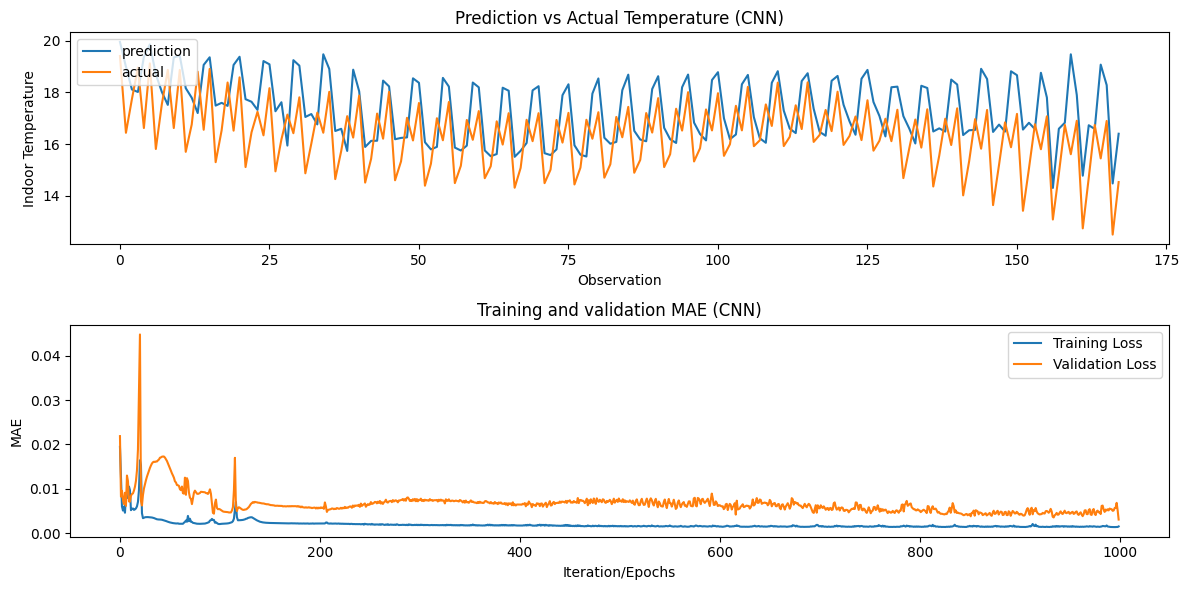

[[0.722457461090872, 0.05169107269462219, 0.06546378412644, 36668749979.31834, 0.3483092553827907, 0.06425829304468515, 0.07817783333879676, 0.1181955052352202]]


In [42]:

y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)
y_test_inv = scaler_y.inverse_transform(y_test)

results = []

print('---------------------------------------------------')
print(f'CNN evaluation for train set:')
train_report = regression_report(y_train, y_train_pred)
print(train_report)
print(f'CNN evaluation for test set:')
test_report = regression_report(y_pred,y_test)
print(test_report)
print('---------------------------------------------------')
y_pred_actual = scaler_y.inverse_transform(y_pred)
print('')
plot_results(y_pred_actual, y_test_inv, history,'CNN')

results.append([
        train_report['R2 Score'], train_report['Mean Absolute Error (MAE)'], train_report['Root Mean Squared Error (RMSE)'], train_report['Mean Absolute Percentage Error (MAPE)'],
        test_report['R2 Score'], test_report['Mean Absolute Error (MAE)'], test_report['Root Mean Squared Error (RMSE)'], test_report['Mean Absolute Percentage Error (MAPE)']
    ])

print(results)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_49"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_17 (GRU)                         │ (None, 16)                  │           1,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_59               │ (None, 16)                  │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_49 (Dense)                     │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,953 (7.63 KB)

 Trainable params: 1,921 (7.50 KB)

 Non-trainable params: 32 (128.00 B)

Epoch 1/1000
50/50 - 2s - 36ms/step - loss: 0.2416 - mae: 0.5392 - val_loss: 0.4100 - val_mae: 0.8667
Epoch 2/1000
50/50 - 0s - 5ms/step - loss: 0.1029 - mae: 0.3322 - val_loss: 0.2146 - val_mae: 0.5876
Epoch 3/1000
50/50 - 0s - 5ms/step - loss: 0.0581 - mae: 0.2500 - val_loss: 0.1706 - val_mae: 0.5060
Epoch 4/1000
50/50 - 0s - 5ms/step - loss: 0.0401 - mae: 0.2108 - val_loss: 0.1556 - val_mae: 0.4689
Epoch 5/1000
50/50 - 0s - 5ms/step - loss: 0.0313 - mae: 0.1879 - val_loss: 0.1460 - val_mae: 0.4406
Epoch 6/1000
50/50 - 0s - 5ms/step - loss: 0.0260 - mae: 0.1722 - val_loss: 0.1378 - val_mae: 0.4163
Epoch 7/1000
50/50 - 0s - 5ms/step - loss: 0.0224 - mae: 0.1603 - val_loss: 0.1308 - val_mae: 0.3973
Epoch 8/1000
50/50 - 0s - 5ms/step - loss: 0.0198 - mae: 0.1508 - val_loss: 0.1245 - val_mae: 0.3826
Epoch 9/1000
50/50 - 0s - 5ms/step - loss: 0.0177 - mae: 0.1427 - val_loss: 0.1185 - val_mae: 0.3703
Epoch 10/1000
50/50 - 0s - 5ms/step - loss: 0.0159 - mae: 0.1356 - val_loss: 0.1125 - val_

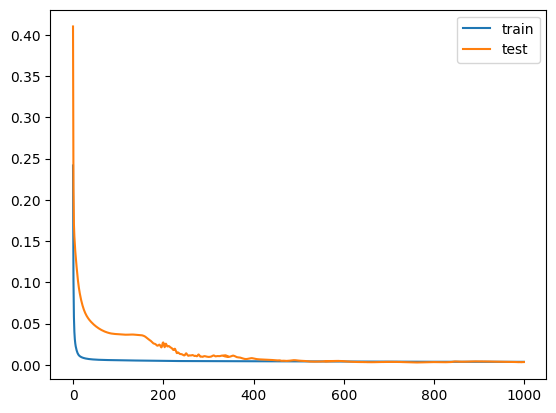

176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
613/613 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
---------------------------------------------------
GRU evaluation for train set:
{'Mean Absolute Error (MAE)': 0.03273664430552575, 'Mean Squared Error (MSE)': 0.0019210318538600624, 'Root Mean Squared Error (RMSE)': 0.04382957738628177, 'Mean Absolute Percentage Error (MAPE)': 14520737757.843508, 'R2 Score': 0.8755881033340052}
GRU evaluation for test set:
{'Mean Absolute Error (MAE)': 0.06637377354998458, 'Mean Squared Error (MSE)': 0.007046951122632638, 'Root Mean Squared Error (RMSE)': 0.08394612035485999, 'Mean Absolute Percentage Error (MAPE)': 0.13652095896006422, 'R2 Score': 0.5052302568572009}
---------------------------------------------------



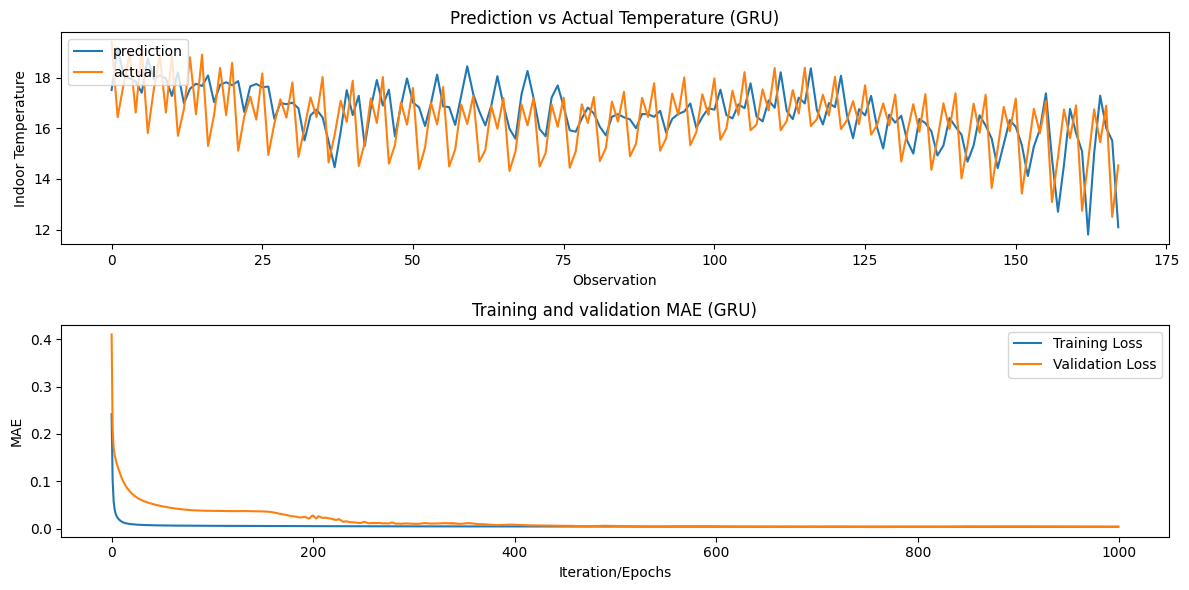

[[0.8755881033340052, 0.03273664430552575, 0.04382957738628177, 14520737757.843508, 0.5052302568572009, 0.06637377354998458, 0.08394612035485999, 0.13652095896006422]]


In [104]:
# design network
model = keras.Sequential()
model.add(layers.GRU(16, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(layers.BatchNormalization())
model.add(layers.Dense(1))

optimizer = Adam()
model.compile(loss='Huber',optimizer=optimizer, metrics=['mae'])

model.summary()

# fit network
history = model.fit(X_train, y_train, epochs=1000, batch_size=400,validation_data=(X_test, y_test), verbose=2, shuffle=False)  #, verbose=2, shuffle=False

# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()


y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)
y_test_inv = scaler_y.inverse_transform(y_test)

results = []

print('---------------------------------------------------')
print(f'GRU evaluation for train set:')
train_report = regression_report(y_train, y_train_pred)
print(train_report)
print(f'GRU evaluation for test set:')
test_report = regression_report(y_pred,y_test)
print(test_report)
print('---------------------------------------------------')
y_pred_actual = scaler_y.inverse_transform(y_pred)
print('')
plot_results(y_pred_actual, y_test_inv, history,'GRU')

results.append([
        train_report['R2 Score'], train_report['Mean Absolute Error (MAE)'], train_report['Root Mean Squared Error (RMSE)'], train_report['Mean Absolute Percentage Error (MAPE)'],
        test_report['R2 Score'], test_report['Mean Absolute Error (MAE)'], test_report['Root Mean Squared Error (RMSE)'], test_report['Mean Absolute Percentage Error (MAPE)']
    ])

print(results)

In [105]:
print(model.summary())
model.save('model_gru.h5')

Model: "sequential_49"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_17 (GRU)                         │ (None, 16)                  │           1,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_59               │ (None, 16)                  │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_49 (Dense)                     │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,797 (22.65 KB)

 Trainable params: 1,921 (7.50 KB)

 Non-trainable params: 32 (128.00 B)

 Optimizer params: 3,844 (15.02 KB)

None


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_46"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_57 (Conv2D)                   │ (None, 6, 21, 32)           │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_46 (MaxPooling2D)      │ (None, 3, 10, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_56               │ (None, 3, 10, 32)           │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_24 (Flatten)                 │ (None, 960)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_46 (Dense)                     │ (None, 1)                   │             961 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,409 (5.50 KB)

 Trainable params: 1,345 (5.25 KB)

 Non-trainable params: 64 (256.00 B)

Epoch 1/1000
50/50 - 4s - 72ms/step - loss: 0.1263 - mae: 0.3706 - val_loss: 0.0419 - val_mae: 0.2402
Epoch 2/1000
50/50 - 0s - 3ms/step - loss: 0.0220 - mae: 0.1639 - val_loss: 0.0573 - val_mae: 0.2965
Epoch 3/1000
50/50 - 0s - 2ms/step - loss: 0.0356 - mae: 0.2184 - val_loss: 0.0583 - val_mae: 0.2993
Epoch 4/1000
50/50 - 0s - 3ms/step - loss: 0.0221 - mae: 0.1666 - val_loss: 0.0709 - val_mae: 0.3398
Epoch 5/1000
50/50 - 0s - 2ms/step - loss: 0.0347 - mae: 0.2164 - val_loss: 0.0678 - val_mae: 0.3248
Epoch 6/1000
50/50 - 0s - 3ms/step - loss: 0.0226 - mae: 0.1681 - val_loss: 0.0551 - val_mae: 0.2973
Epoch 7/1000
50/50 - 0s - 3ms/step - loss: 0.0402 - mae: 0.2346 - val_loss: 0.0463 - val_mae: 0.2620
Epoch 8/1000
50/50 - 0s - 3ms/step - loss: 0.0211 - mae: 0.1615 - val_loss: 0.0337 - val_mae: 0.2290
Epoch 9/1000
50/50 - 0s - 3ms/step - loss: 0.0436 - mae: 0.2428 - val_loss: 0.0372 - val_mae: 0.2354
Epoch 10/1000
50/50 - 0s - 3ms/step - loss: 0.0224 - mae: 0.1674 - val_loss: 0.0288 - val_

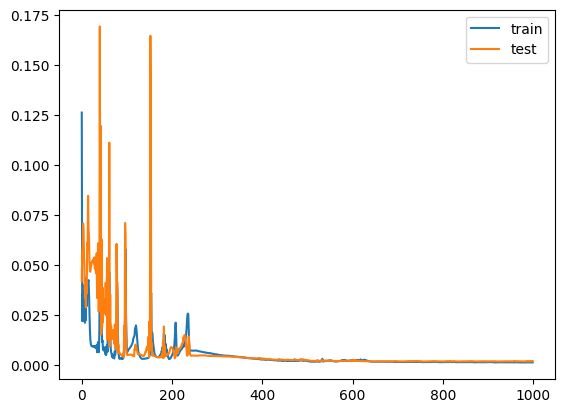

176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
613/613 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
---------------------------------------------------
CNN evaluation for train set:
{'Mean Absolute Error (MAE)': 0.040542933384754856, 'Mean Squared Error (MSE)': 0.0028847253080401414, 'Root Mean Squared Error (RMSE)': 0.05370963887460184, 'Mean Absolute Percentage Error (MAPE)': 23548429895.27188, 'R2 Score': 0.8131763686205831}
CNN evaluation for test set:
{'Mean Absolute Error (MAE)': 0.04913179984474639, 'Mean Squared Error (MSE)': 0.0039046409051455224, 'Root Mean Squared Error (RMSE)': 0.06248712591522771, 'Mean Absolute Percentage Error (MAPE)': 0.08936524479297239, 'R2 Score': 0.6929363401139337}
---------------------------------------------------



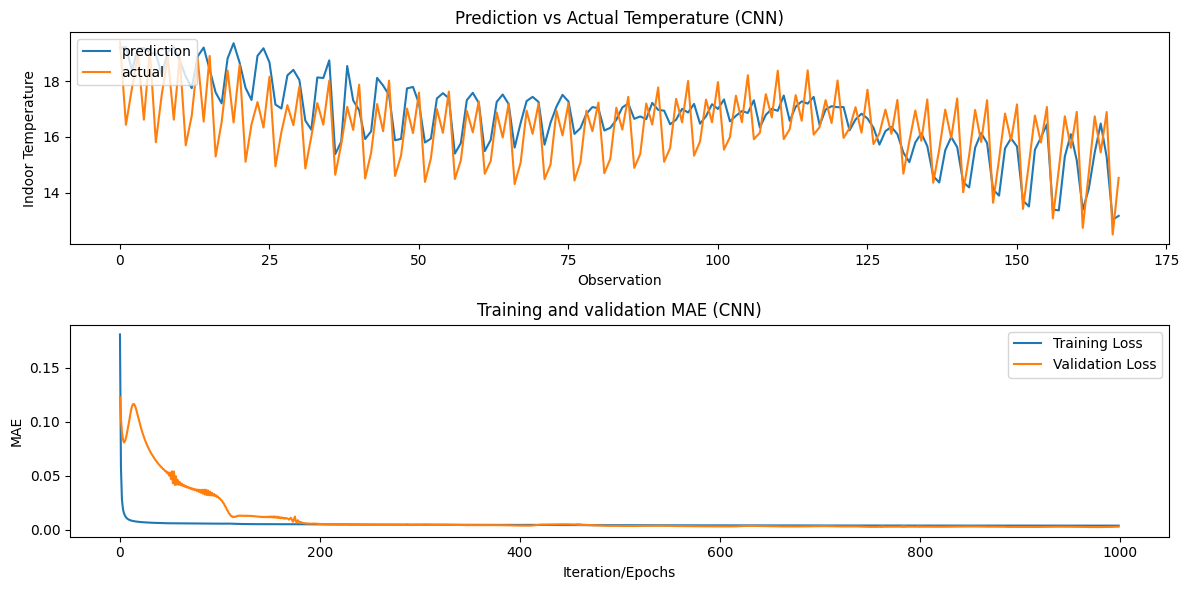

[[0.8131763686205831, 0.040542933384754856, 0.05370963887460184, 23548429895.27188, 0.6929363401139337, 0.04913179984474639, 0.06248712591522771, 0.08936524479297239]]


In [96]:
# design network
model_cnn = keras.Sequential()
model_cnn.add(layers.Conv2D(32, (3,3), activation = 'relu', input_shape=(X_train.shape[1], X_train.shape[2],1), padding='same'))
model_cnn.add(layers.MaxPooling2D((2,2)))
model_cnn.add(layers.BatchNormalization())
# model_cnn.add(layers.Conv2D(32, (3,3), activation = 'relu', input_shape=(X_train.shape[1], X_train.shape[2],1), padding='same'))
# model_cnn.add(layers.AveragePooling2D((2,2)))
# model_cnn.add(layers.BatchNormalization())

model_cnn.add(layers.Flatten())
model_cnn.add(layers.Dense(1, activation='linear'))

optimizer = Adam()
model_cnn.compile(loss='Huber',optimizer=optimizer, metrics=['mae'])

model_cnn.summary()

# fit network
history_cnn = model_cnn.fit(X_train, y_train, epochs=1000, batch_size=400,validation_data=(X_test, y_test), verbose=2, shuffle=False)  #, verbose=2, shuffle=False

# plot history
plt.plot(history_cnn.history['loss'], label='train')
plt.plot(history_cnn.history['val_loss'], label='test')
plt.legend()
plt.show()


y_pred = model_cnn.predict(X_test)
y_train_pred = model_cnn.predict(X_train)
y_test_inv = scaler_y.inverse_transform(y_test)

results = []

print('---------------------------------------------------')
print(f'CNN evaluation for train set:')
train_report = regression_report(y_train, y_train_pred)
print(train_report)
print(f'CNN evaluation for test set:')
test_report = regression_report(y_pred,y_test)
print(test_report)
print('---------------------------------------------------')
y_pred_actual = scaler_y.inverse_transform(y_pred)
print('')
plot_results(y_pred_actual, y_test_inv, history,'CNN')

results.append([
        train_report['R2 Score'], train_report['Mean Absolute Error (MAE)'], train_report['Root Mean Squared Error (RMSE)'], train_report['Mean Absolute Percentage Error (MAPE)'],
        test_report['R2 Score'], test_report['Mean Absolute Error (MAE)'], test_report['Root Mean Squared Error (RMSE)'], test_report['Mean Absolute Percentage Error (MAPE)']
    ])

print(results)

In [106]:
model_cnn.save(filepath='model_cnn.h5')